In this notebook, I open a basicos_distritos_viajes file from whatever day, by using the open_gz function.

Then, I filter only Madrid districts in the dataset by using the function filter_district, and selecting those entries starting by 28079.

LIMITATION: I also do an extra filter on top of the Madrid district filter, just in case: I select those entries for which the 'actividad_origen' is 'casa', or 'actividad_destino' is 'casa', or both. The reason is that the residence of the users in the MITMA data is not by district, but by province. This could be a problem as I am trying to understand how people from different districts move, and it turns out I do not have individual district data on where the user's residence is, only province data. As a solution, by applying the previously mentioned filters, I can access the actual district of residence individually. The problem is that the mobility would be very limited to those trips either coming from or going home, hence reducing the richness of the dataset and the study overall.

Another solution would be to ignore the 'residence' variable and just focus on mobility around districts independently, maybe focusing on other variables like 'income'.

## TO DO:

1. Filter network based on purpose: people who go from home to work, from work to home, leisure, etc. Maybe filter as well by hours.
2. Calculate an 'amenity Moran's I' on top of the already calculated income moran's I, in segregation_indices.

In [38]:
import config as cfg
import os
import pandas as pd
from utils import get_overview, open_gz, filter_district
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

geometria_dir = cfg.GEOMETRIA_DATA
personas_dir = cfg.PERSONAS_DATA
viajes_dir = cfg.VIAJES_DATA

# FIXME: Read more about DtypeWarning and fix
viajes_1_2_3 = open_gz(viajes_dir / 'basicos_distritos_viajes_202406', [18]) # substracting all trips in all districts of Spain during day 1st, 2nd and 3rd of June
viajes_1 = viajes_1_2_3[0] # accessing the first stored day (June 1st)
madrid_1 = filter_district(viajes_1, '28079')

# NOTE: The residence of the users in the MITMA data is not by district, but by province. 
# This could be a problem as I am trying to understand how people from different districts move. 
# As a solution, I could filter to only use ‘origen’ == casa or ‘destino’==casa in the districts of Madrid. 
# This way, I could make sure that I am taking a look at those records of people who actually live in a specific district in Madrid.
# The problem is that the mobility would be very limited to those trips either coming from or going home.
home_trips = madrid_1.loc[(madrid_1['actividad_origen'] == 'casa') | (madrid_1['actividad_destino'] == 'casa')]
filtered_df, _ = train_test_split(home_trips, train_size=5000, stratify=home_trips['renta'], random_state=42) # selecting a balanced sample

/Users/caro/Desktop/thesis_project/mobility_data/utils.py:33: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, compression='gzip', sep='|') # Read the compressed CSV file


In [39]:
# Step 1: Load the GeoJSON file
gdf = gpd.read_file('/Users/caro/Desktop/thesis_project/mobility_data/ZONIFICACION/distritos/madrid_gdf.geojson')  # Load your GeoJSON file into a GeoDataFrame

# Step 2: Create a function to get the centroid of each district (or use other geometry)
# We'll use the 'ID' as the node identifier and the centroid of the polygon as the position
positions = {}
for idx, row in gdf.iterrows():
    district_id = row['ID']  # Assuming 'ID' is the district identifier matching the graph
    centroid = row['geometry'].centroid  # Get the centroid of the district's polygon
    positions[district_id] = (centroid.x, centroid.y)  # Store the centroid coordinates

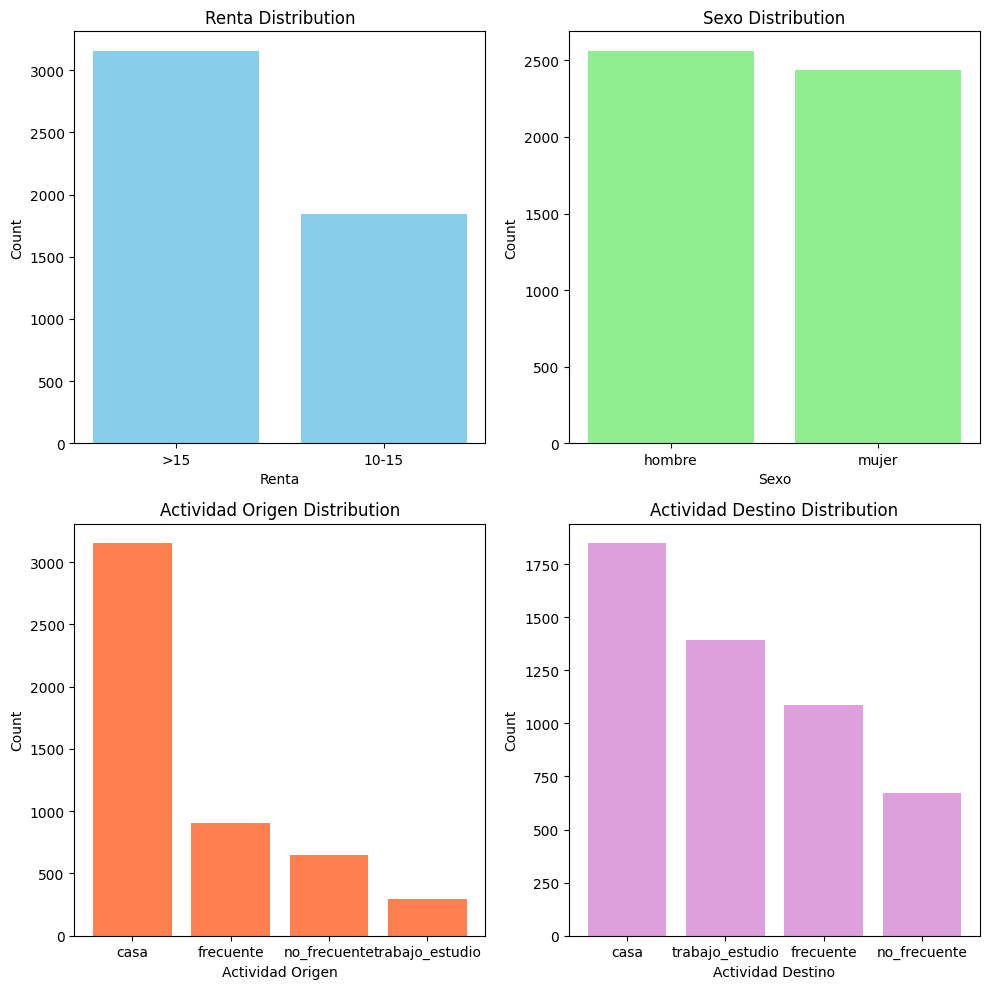

In [40]:
# Get distribution of renta
renta_distribution = filtered_df['renta'].value_counts()

# Get distribution of sexo
sexo_distribution = filtered_df['sexo'].value_counts()

# Get distribution of actividad_origen and actividad_destino
actividad_origen_distribution = filtered_df['actividad_origen'].value_counts()
actividad_destino_distribution = filtered_df['actividad_destino'].value_counts()

# Plot distributions
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Renta distribution
axes[0, 0].bar(renta_distribution.index, renta_distribution.values, color='skyblue')
axes[0, 0].set_title('Renta Distribution')
axes[0, 0].set_xlabel('Renta')
axes[0, 0].set_ylabel('Count')

# Sexo distribution
axes[0, 1].bar(sexo_distribution.index, sexo_distribution.values, color='lightgreen')
axes[0, 1].set_title('Sexo Distribution')
axes[0, 1].set_xlabel('Sexo')
axes[0, 1].set_ylabel('Count')

# Actividad Origen distribution
axes[1, 0].bar(actividad_origen_distribution.index, actividad_origen_distribution.values, color='coral')
axes[1, 0].set_title('Actividad Origen Distribution')
axes[1, 0].set_xlabel('Actividad Origen')
axes[1, 0].set_ylabel('Count')

# Actividad Destino distribution
axes[1, 1].bar(actividad_destino_distribution.index, actividad_destino_distribution.values, color='plum')
axes[1, 1].set_title('Actividad Destino Distribution')
axes[1, 1].set_xlabel('Actividad Destino')
axes[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()

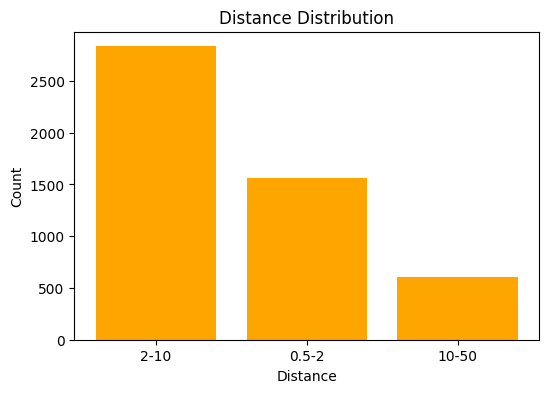

In [41]:
distancia_distribution = filtered_df['distancia'].value_counts()

# Plot distance distribution
plt.figure(figsize=(6, 4))
plt.bar(distancia_distribution.index, distancia_distribution.values, color='orange')
plt.title('Distance Distribution')
plt.xlabel('Distance')
plt.ylabel('Count')
plt.show()

In [42]:
len(filtered_df)

5000

In [43]:
def define_graph_gender(df, weight_column):
    # filters to plot -- the edge color will change based on these filters
    attr1 = df[df['renta'] == '>15']
    attr2 = df[df['renta'] == '10-15']
    # print("Hombres edges:", len(attr1))
    # print("Mujeres edges:", len(attr2))

    G = nx.DiGraph() 
    # add edges with attribute 1
    for idx, row in attr1.iterrows():
        G.add_edge(row['origen'], row['destino'], weight=row[weight_column], type='attr1')

    # add edges with attribute 2
    for idx, row in attr2.iterrows():
        G.add_edge(row['origen'], row['destino'], weight=row[weight_column], type='attr2')

    return G

def set_art(G):
    
    edge_colors = []
    edge_widths = []
    for u, v, data in G.edges(data=True):
        # print(f"Edge from {u} to {v}: Type={data['type']}, Weight={data['weight']}")
        # Set edge color based on the type
        if data['type'] == 'attr1':
            edge_colors.append('blue')  # attr1 edges will be blue
        else:
            edge_colors.append('red')   # attr2 edges will be red
        
        # Set edge width based on the number of trips (weight)
        edge_widths.append(data['weight'] / 15)  # Scale down weight for visualization purposes

    return edge_colors, edge_widths

def plot_graph_and_background(G, pos, edge_colors, edge_widths, node_size, node_color, background, alpha):

    fig, ax = plt.subplots(figsize=(10, 15))
    background.plot(ax=ax, color='green', edgecolor='green', alpha=alpha)
    nx.draw(G, pos=pos, with_labels=True, edge_color=edge_colors, width=edge_widths, node_size=node_size, node_color=node_color, ax=ax)
    plt.show()

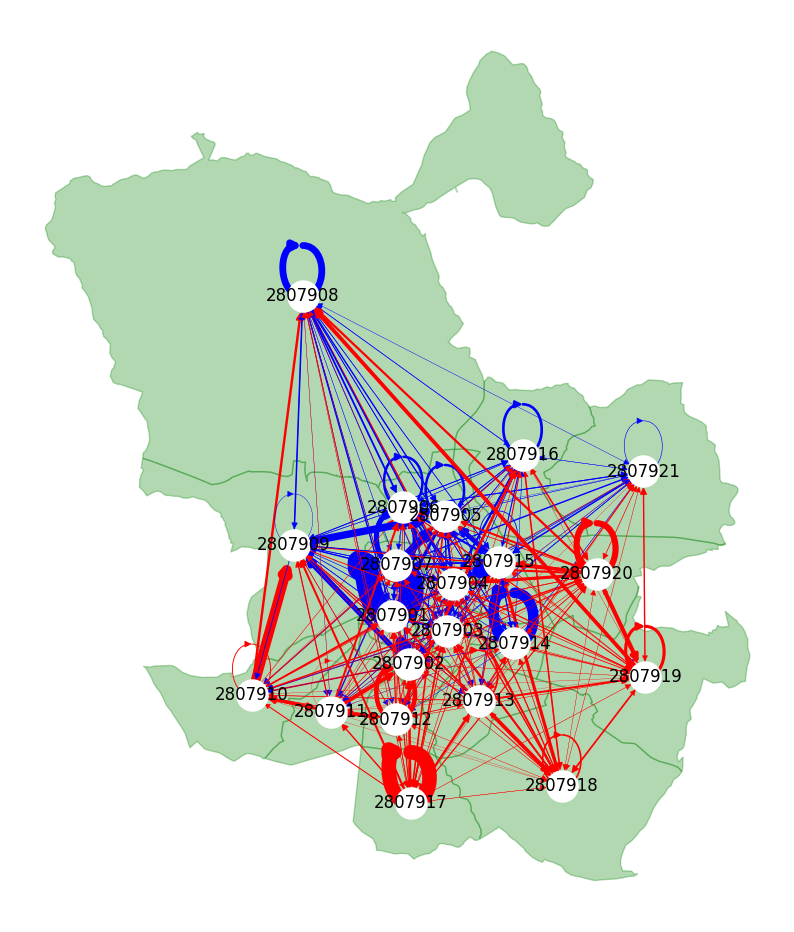

In [44]:
G = define_graph_gender(filtered_df, 'viajes')
edge_colors, edge_widths = set_art(G)
plot_graph_and_background(G, positions, edge_colors, edge_widths, 500, 'white', gdf, 0.3)

In [45]:
nx.degree_centrality(G)

{'2807907': 2.0,
 '2807918': 2.0,
 '2807916': 2.0500000000000003,
 '2807905': 1.85,
 '2807903': 2.1,
 '2807906': 1.85,
 '2807901': 1.9500000000000002,
 '2807921': 1.85,
 '2807908': 1.9500000000000002,
 '2807902': 2.0500000000000003,
 '2807904': 1.85,
 '2807910': 1.6,
 '2807914': 1.6500000000000001,
 '2807920': 2.0,
 '2807917': 2.0500000000000003,
 '2807909': 1.9500000000000002,
 '2807911': 1.7000000000000002,
 '2807915': 2.0500000000000003,
 '2807913': 1.75,
 '2807912': 1.8,
 '2807919': 1.9500000000000002}

In [46]:
nx.closeness_centrality(G)

{'2807907': 1.0,
 '2807918': 1.0,
 '2807916': 1.0,
 '2807905': 1.0,
 '2807903': 1.0,
 '2807906': 0.9523809523809523,
 '2807901': 1.0,
 '2807921': 1.0,
 '2807908': 0.9523809523809523,
 '2807902': 1.0,
 '2807904': 1.0,
 '2807910': 0.6896551724137931,
 '2807914': 0.6896551724137931,
 '2807920': 1.0,
 '2807917': 1.0,
 '2807909': 0.9090909090909091,
 '2807911': 0.7407407407407407,
 '2807915': 1.0,
 '2807913': 0.7407407407407407,
 '2807912': 0.8,
 '2807919': 1.0}

In [47]:
nx.betweenness_centrality(G)

{'2807907': 0.007493236411172699,
 '2807918': 0.005797359188979686,
 '2807916': 0.00852823941985992,
 '2807905': 0.0006663863606384382,
 '2807903': 0.010256452727020594,
 '2807906': 0.0022029323016165125,
 '2807901': 0.005125479898679344,
 '2807921': 0.0020421560587765577,
 '2807908': 0.00505373877430664,
 '2807902': 0.00788869621452724,
 '2807904': 0.0015791139838923773,
 '2807910': 0.0013922942247041972,
 '2807914': 0.0033333392907492626,
 '2807920': 0.005797359188979686,
 '2807917': 0.01011794857189594,
 '2807909': 0.006097048534721666,
 '2807911': 0.003317693386945464,
 '2807915': 0.0075255724961403635,
 '2807913': 0.004272685032726584,
 '2807912': 0.0039620891958149565,
 '2807919': 0.005444915579957129}

In [48]:
nx.average_shortest_path_length(G)

1.0976190476190477

In [49]:
len(G.edges)

400

In [50]:
len(G.nodes)

21

In [51]:
nx.betweenness_centrality(G, weight='weight')

{'2807907': 0.021052631578947368,
 '2807918': 0.04473684210526316,
 '2807916': 0.013157894736842105,
 '2807905': 0.010526315789473684,
 '2807903': 0.002631578947368421,
 '2807906': 0.010526315789473684,
 '2807901': 0.007894736842105263,
 '2807921': 0.05526315789473684,
 '2807908': 0.013157894736842105,
 '2807902': 0.021052631578947368,
 '2807904': 0.005263157894736842,
 '2807910': 0.005263157894736842,
 '2807914': 0.018421052631578946,
 '2807920': 0.08157894736842106,
 '2807917': 0.06578947368421052,
 '2807909': 0.0,
 '2807911': 0.018421052631578946,
 '2807915': 0.02894736842105263,
 '2807913': 0.02631578947368421,
 '2807912': 0.010526315789473684,
 '2807919': 0.1631578947368421}